In [2]:
import os
import pandas as pd
import numpy as np

input_dir = "/content/drive/MyDrive/Cell_Class"

In [3]:
folders = [f for f in os.walk(input_dir)]

In [87]:
classes = folders[0][1]
classes = {v: i for i, v in enumerate(classes)}

In [5]:
df = {"name": [], "category": [], "dir": []}

In [6]:
for c in classes:
    c_dir = os.path.join(input_dir, c)
    for filename in os.listdir(c_dir):
        df["name"].append(filename)
        df["category"].append(c)
        df["dir"].append(os.path.join(c_dir, filename))
        
df = pd.DataFrame(df)

In [7]:
df

,name,category,dir
0,NG-6-Cells5_9.jpg,Cross Line,/content/drive/MyDrive/Cell_Class/Cross Line/N...
1,NG-6-Cells3_5.jpg,Cross Line,/content/drive/MyDrive/Cell_Class/Cross Line/N...
2,NG-90-Cells2_0.jpg,Cross Line,/content/drive/MyDrive/Cell_Class/Cross Line/N...
3,NG-6-Cells5_8.jpg,Snowflake Spot,/content/drive/MyDrive/Cell_Class/Snowflake Sp...
4,NG-6-Cells4_7.jpg,Snowflake Spot,/content/drive/MyDrive/Cell_Class/Snowflake Sp...
...,...,...,...
615,NG-528-Cells0_1.jpg,Cold Soldering,/content/drive/MyDrive/Cell_Class/Cold Solderi...
616,NG-528-Cells0_5.jpg,Cold Soldering,/content/drive/MyDrive/Cell_Class/Cold Solderi...
617,NG-528-Cells5_8.jpg,Cold Soldering,/content/drive/MyDrive/Cell_Class/Cold Solderi...
618,NG-528-Cells0_6.jpg,Cold Soldering,/content/drive/MyDrive/Cell_Class/Cold Solderi...


In [8]:
N = len(df)

In [9]:
import matplotlib.pyplot as plt

Snowflake Spot


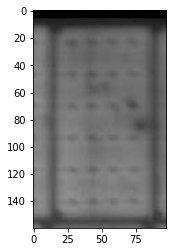

In [10]:
random_id = np.random.randint(0, N)
random_img, random_label = plt.imread(df["dir"][random_id]), df["category"][random_id]
print(random_label)
plt.imshow(random_img)

In [11]:
len(df["category"].value_counts())

11

In [12]:
random_img.shape

(160, 98, 3)

# Train Model

In [13]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [14]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [15]:
data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

In [89]:
import torch.utils.data as data

dataset = datasets.ImageFolder(input_dir, transform = data_transform)
train_set_size = int(len(dataset)*0.8)
valid_set_size = len(dataset) - train_set_size

images_datasets = {}
images_datasets['train'], images_datasets['valid'] = data.random_split(dataset, [train_set_size, valid_set_size])

In [97]:
classes = {v: k for (k, v) in dataset.class_to_idx.items()}

In [39]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(images_datasets['train'],
                                batch_size=32,
                                shuffle=True),
    'validation':
    torch.utils.data.DataLoader(images_datasets['valid'],
                                batch_size=32,
                                shuffle=False)
}

Create Resnet50

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [41]:
model = models.resnet50(weights=True).to(device)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 128), nn.ReLU(inplace=True), 
                         nn.Linear(128, 11)).to(device)


In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

Train model

In [45]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                _, preds = torch.max(outputs, 1)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(images_datasets[phase])
            epoch_acc = running_corrects.double() / len(images_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [47]:
model_trained = train_model(model, criterion, optimizer, num_epochs = 10)

Epoch 1/10
----------
train loss: 0.9107, acc: 0.7097
valid loss: 0.9392, acc: 0.6935
Epoch 2/10
----------
train loss: 0.8472, acc: 0.7177
valid loss: 0.9357, acc: 0.6935
Epoch 3/10
----------
train loss: 0.7738, acc: 0.7581
valid loss: 1.0227, acc: 0.6452
Epoch 4/10
----------
train loss: 0.7322, acc: 0.7560
valid loss: 0.9615, acc: 0.6855
Epoch 5/10
----------
train loss: 0.7087, acc: 0.7540
valid loss: 0.8723, acc: 0.7016
Epoch 6/10
----------
train loss: 0.6513, acc: 0.7782
valid loss: 0.9122, acc: 0.7339
Epoch 7/10
----------
train loss: 0.6085, acc: 0.7964
valid loss: 0.8911, acc: 0.7258
Epoch 8/10
----------
train loss: 0.5750, acc: 0.8004
valid loss: 0.9323, acc: 0.7258
Epoch 9/10
----------
train loss: 0.5931, acc: 0.7802
valid loss: 0.8452, acc: 0.7177
Epoch 10/10
----------
train loss: 0.5417, acc: 0.8145
valid loss: 0.7480, acc: 0.7339


# Save model

In [48]:
!mkdir models
!mkdir models/pytorch

In [49]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [50]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 11)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [58]:
test_dir = '/content/drive/MyDrive/data/Cell_Class_Test'

In [59]:
test_files = os.listdir(test_dir)

In [76]:
from PIL import Image

In [77]:
images = [Image.open(os.path.join(test_dir, filename)) for filename in test_files]

In [81]:
test_batch = torch.stack([data_transform(img).to(device) for img in images])

In [ ]:
pred_logits = model(test_batch)
pred_logits

In [95]:
pred_probs = F.softmax(pred_logits, dim=1).cpu().data.numpy()
pred = np.argmax(pred_probs, axis=1)

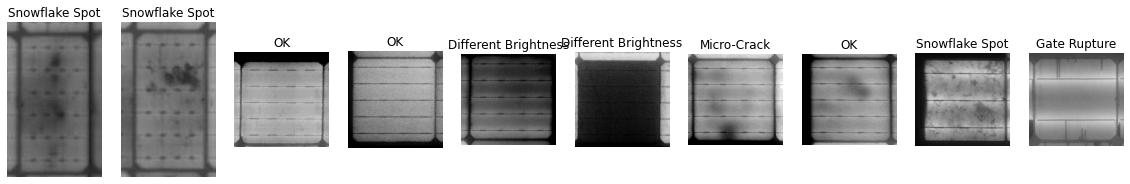

In [98]:
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i, img in enumerate(images[:10]):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(classes[pred[i]])
    ax.imshow(img)